# Blind case study: "caught" feature

# Setup

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Load model

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder

In [3]:
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2')

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


## Loading data

In [4]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
from datasets import load_dataset
from huggingface_hub import HfApi

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

# Load transcoders

In [7]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
sparsities = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    sparsities.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Load transcoder 8 feature frequency info

In [11]:
live_features = np.arange(len(sparsities[8]))[utils.to_numpy(sparsities[8] > -4)]

In [ ]:
np.mean(transcoders_losses['real_losses']),\
    np.mean(transcoders_losses['transcoder_losses']),\
    np.mean(transcoders_losses['ablated_losses'])

In [ ]:
transcoders_losses = eval_transcoders_cross_entropy(model, transcoders[1:11], only_get_transcoder_loss=True)

In [ ]:
np.mean(transcoders_losses['transcoder_losses'])

# Blind feature case study! (`live_features[200]`)

In a blind feature case study, we try to begin by reverse-engineering a transcoder feature *without looking at the top-activating examples*. We then form a hypothesis about what the transcoder feature is computing, and only after having done so do we look at the top-activating examples to see if our hypothesis is supported.

In [37]:
feature_idx = live_features[200]
my_feature = make_sae_feature_vector(transcoders[8], feature_idx, use_encoder=True, token=-1)
print(my_feature)

mlp8tc[235]@-1


In [15]:
# get scores
scores = get_feature_scores(model, transcoders[8], owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
uniform_samples = sample_uniform(scores, num_samples=50)

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


Let's get the indices of sufficiently-highly activating examples.

In [16]:
uniform_scores, uniform_idxs = uniform_samples[0], uniform_samples[1]
print(uniform_scores)

[ 0.      0.4524  0.9155  1.369   1.837   2.318   2.746   3.064   3.65
  4.14    4.58    5.06    5.414   5.965   6.156   6.66    7.348   7.85
  8.68   10.414  10.664  11.77   12.6    12.83   13.12   13.96   14.98
 15.55   15.766  16.45   17.14   17.44   17.73   18.36   18.75   19.38
 19.64   20.17   20.64   21.19   21.4    21.88   22.4   ]


In [17]:
threshold = 17.0
uniform_idxs = uniform_idxs[uniform_scores>threshold]
uniform_scores = uniform_scores[uniform_scores>threshold]
print(uniform_idxs)

[[ 9687   105]
 [  837    13]
 [ 1399   123]
 [11713    34]
 [ 4644    86]
 [ 6801    70]
 [ 1417    46]
 [  817    63]
 [ 8531   111]
 [  755    73]
 [ 6299    39]
 [ 1077   112]
 [11390    41]]


## Input 8531, 111

In [18]:
prompt = owt_tokens_torch[8531, :111+1]
_, cache = model.run_with_cache(prompt)

In [23]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@111: 2.1e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@111: 1.5e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@111: 7.9
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@111: 6.9
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@111: 5.7
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@111: 5.6
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@111: 4.8
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@111: 4.4
Path [0][8]: mlp8tc[235]@-1 <- attn5[7]@111: 3.6
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@111: 2.5
Path [0][10]: mlp8tc[235]@-1 <- attn0[1]@111: 2.2
Path [0][11]: mlp8tc[235]@-1 <- attn0[5]@111: 1.6
Path [0][12]: mlp8tc[235]@-1 <- mlp7tc[760]@111: 1.4
Path [0][13]: mlp8tc[235]@-1 <- attn8[4]@111: 1.4
Path [0][14]: mlp8tc[235]@-1 <- embed0@111: 1.3
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@111: 1.5e+01 <- attn0[1]@111: 6.1
Path [1][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@111: 1.5e+01 <- attn0[4]@111: 5.6
Path [1][2

Looks like almost all of our importance comes from the final token in the input. 

### Input-independent information

Let's look at `mlp7tc[14382]@-1`. Which MLP0 transcoder features is it -- input-indepedently -- most connected to?

In [153]:
cur_feature = all_paths[2][1][1]
print(cur_feature)

mlp7tc[14382]@-1: 2.1e+01


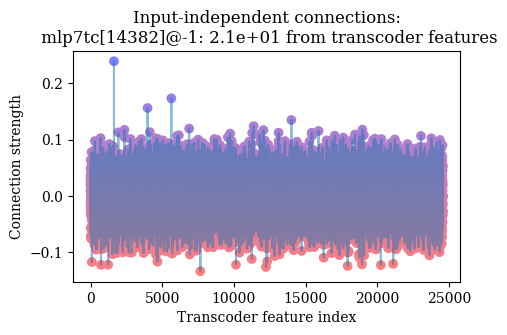

In [160]:
display_transcoder_pullback_features(model, cur_feature, transcoders[0])

In [161]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 1636, k=2)

In [162]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 5637, k=2)

In [163]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 3981, k=2)

In [166]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 14013, k=5)

In [24]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 11383, k=2)

*Current hypothesis*: feature fires on forms of the verb "catch", "captured". Probably news articles about criminals?

## Input 6299, 39

In [171]:
prompt = owt_tokens_torch[6299, :39+1]
_, cache = model.run_with_cache(prompt)

In [172]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 2.2e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.7e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@-1: 8.3
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@-1: 7.1
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@-1: 6.3
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@-1: 6.0
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@-1: 4.8
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@-1: 4.6
Path [0][8]: mlp8tc[235]@-1 <- attn8[4]@39: 3.0
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@39: 2.4
Path [0][10]: mlp8tc[235]@-1 <- attn5[7]@39: 2.3
Path [0][11]: mlp8tc[235]@-1 <- attn0[1]@39: 2.0
Path [0][12]: mlp8tc[235]@-1 <- attn0[5]@39: 1.6
Path [0][13]: mlp8tc[235]@-1 <- mlp2tc[6202]@-1: 1.6
Path [0][14]: mlp8tc[235]@-1 <- mlp7tc[18519]@-1: 1.4
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.7e+01 <- embed0@-1: 6.1
Path [1][1]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 2.2e+01 <- mlp0tc[1636]@-1: 5.9
Path [1][2]: mlp8t

Again, almost all computational paths depend on last token; again, `mlp7tc[14382]` and `mlp0tc[1636]` are the main players.

## Input 817, 63

In [173]:
prompt = owt_tokens_torch[817, :63+1]
_, cache = model.run_with_cache(prompt)

In [174]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=15)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1 <- mlp7tc[14382]@-1: 1.8e+01
Path [0][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01
Path [0][2]: mlp8tc[235]@-1 <- mlp6tc[22733]@-1: 6.4
Path [0][3]: mlp8tc[235]@-1 <- mlp3tc[7628]@-1: 6.1
Path [0][4]: mlp8tc[235]@-1 <- mlp5tc[11575]@-1: 4.4
Path [0][5]: mlp8tc[235]@-1 <- mlp4tc[21770]@-1: 4.3
Path [0][6]: mlp8tc[235]@-1 <- mlp2tc[17511]@-1: 4.0
Path [0][7]: mlp8tc[235]@-1 <- mlp1tc[4598]@-1: 4.0
Path [0][8]: mlp8tc[235]@-1 <- attn8[4]@63: 2.7
Path [0][9]: mlp8tc[235]@-1 <- attn0[4]@63: 2.4
Path [0][10]: mlp8tc[235]@-1 <- attn0[1]@63: 2.1
Path [0][11]: mlp8tc[235]@-1 <- attn0[5]@63: 1.6
Path [0][12]: mlp8tc[235]@-1 <- attn1[0]@62: 1.4
Path [0][13]: mlp8tc[235]@-1 <- mlp7tc[18519]@-1: 1.3
Path [0][14]: mlp8tc[235]@-1 <- mlp7tc[23744]@-1: 1.3
--- Paths of size 3 ---
Path [1][0]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01 <- embed0@-1: 5.7
Path [1][1]: mlp8tc[235]@-1 <- mlp0tc[1636]@-1: 1.6e+01 <- attn0[1]@63: 5.7
Path [1][2]: mlp8tc[23

Same pattern as before.

## Moment of truth: confirming/denying our hypothesis

**Final hypothesis**: largely single-token feature that fires on "caught", "captured", "uncovered", and similar (particularly past-tense) forms of the verb "to catch".

In [175]:
display_activating_examples_dash(owt_tokens_torch[:128*100], scores)

**How'd we do?** We were correct about "caught". However, the other similar verbs (like "captured" and "uncovered") weren't present in the top-activating examples.

Also, it seems that in all the top-activating examples, "caught" is used as a participle, rather than as the past tense of the verb "catch". (E.g. you don't really see any examples like "I caught him!". Is this an important factor for the original feature? 

## Post-mortem: "caught" as participle versus finite verb

In [25]:
test_prompt = "He was caught"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


array([[ 0.  ,  0.  , 19.97]], dtype=float16)

In [26]:
test_prompt = "He caught the ball"
scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
scores

100%|██████████| 1/1 [00:00<00:00, 50.32it/s]


array([[0.    , 0.8145, 0.    , 0.    ]], dtype=float16)

Yep! This is in fact important!

But why didn't this show up in our computational paths? Could it perhaps be that the transcoders are unable to correctly account for this?

In [27]:
test_prompt = "He was caught"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 25.08it/s]

[[ 0.    0.   16.45]]


In [28]:
test_prompt = "He caught the ball"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 48.85it/s]

[[0. 9. 0. 0.]]


Looks like our transcoders don't do a great job of modeling this subtle contextual difference between "caught" as an active verb and "caught" as a past participle. But there still is a difference!

In [29]:
test_prompt = "was caught"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 45.34it/s]

[[ 0.    11.086]]


In [30]:
test_prompt = "then caught"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 49.39it/s]

[[0.   4.85]]


### Filtering for computational paths

Let's see if our circuit analysis finds any computational paths that contribute from the ` was` token.

In [31]:
test_prompt = "He was caught"
with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(test_prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
    _, cache = model.run_with_cache(test_prompt, stop_at_layer=9)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 24.90it/s]

[[ 0.    0.   16.45]]


In [32]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature, num_iters=5, num_branches=30, do_raw_attribution=True)

In [37]:
# only look at paths that go to token 2
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[
    FeatureFilter(token=2)
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[235]@-1 <- attn1[0]@2: 1.0


In [200]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, filtered_paths[0][-1], num_iters=1, num_branches=10, do_raw_attribution=True)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: attn1[0]@2: 1.1 <- mlp0tc[15269]@2: 0.6
Path [0][1]: attn1[0]@2: 1.1 <- mlp0tc[24399]@2: 0.22
Path [0][2]: attn1[0]@2: 1.1 <- mlp0tc[6036]@2: 0.13
Path [0][3]: attn1[0]@2: 1.1 <- mlp0tc[10177]@2: 0.1
Path [0][4]: attn1[0]@2: 1.1 <- attn0[1]@2: 0.061
Path [0][5]: attn1[0]@2: 1.1 <- attn0[7]@1: 0.039
Path [0][6]: attn1[0]@2: 1.1 <- attn0[9]@1: 0.036
Path [0][7]: attn1[0]@2: 1.1 <- attn0[9]@2: 0.028
Path [0][8]: attn1[0]@2: 1.1 <- attn0[7]@2: 0.026
Path [0][9]: attn1[0]@2: 1.1 <- attn0[8]@2: 0.025


In [201]:
display_deembeddings_for_feature_vector(model, subcircuit[0][0][-1])
display_deembeddings_for_feature_vector(model, subcircuit[0][1][-1])
display_deembeddings_for_feature_vector(model, subcircuit[0][2][-1])

In [202]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, filtered_paths[1][-1], num_iters=1, num_branches=10, do_raw_attribution=True)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: attn3[2]@2: 0.7 <- mlp0tc[15269]@2: 0.26
Path [0][1]: attn3[2]@2: 0.7 <- mlp0tc[24399]@2: 0.12
Path [0][2]: attn3[2]@2: 0.7 <- attn0[1]@2: 0.11
Path [0][3]: attn3[2]@2: 0.7 <- mlp0tc[10177]@2: 0.1
Path [0][4]: attn3[2]@2: 0.7 <- mlp1tc[1422]@2: 0.085
Path [0][5]: attn3[2]@2: 0.7 <- attn1[10]@2: 0.063
Path [0][6]: attn3[2]@2: 0.7 <- attn1[10]@1: 0.051
Path [0][7]: attn3[2]@2: 0.7 <- attn2[3]@1: 0.049
Path [0][8]: attn3[2]@2: 0.7 <- mlp0tc[6036]@2: 0.048
Path [0][9]: attn3[2]@2: 0.7 <- mlp1tc[15836]@2: 0.045


So we do see some mild attribution to transcoder features that fire on "was". But why are these attribution scores so low compared to the striking difference in feature activation when "was" is present versus when it's absent?

Let's now go further and do some causal analysis -- it's patching time!

### Patching

In [45]:
test_prompt = "was caught"
print(model.to_str_tokens(test_prompt))
_, cache = model.run_with_cache(test_prompt)

['<|endoftext|>', 'was', ' caught']


In [14]:
bad_test_prompt = "then caught"
print(model.to_str_tokens(bad_test_prompt))
_, bad_cache = model.run_with_cache(bad_test_prompt)

['<|endoftext|>', 'then', ' caught']


First, we'll patch the output of every attention sublayer and every MLP sublayer.

In [17]:
patch_scores = np.zeros((8*2,2))

def hook_patch(activation, hook):
    activation[:, cur_token, :] = cache[hook.name][:, cur_token, :]
    return activation

for layer in range(8):
    for i, token in enumerate(range(1,3)):
        cur_token = token
        with TranscoderReplacementContext(model, transcoders[:8]):
            with model.hooks(fwd_hooks=[(utils.get_act_name('attn_out', layer), hook_patch)]):
                _, patched_cache = model.run_with_cache(bad_test_prompt)
                #new_activation = transcoders[8](patched_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                #old_activation = transcoders[8](bad_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                new_activation = (transcoders[8].W_enc[:,feature_idx] @ patched_cache[utils.get_act_name('normalized8ln2')][0,-1]).item()
                old_activation = (transcoders[8].W_enc[:,feature_idx] @ bad_cache[utils.get_act_name('normalized8ln2')][0,-1]).item()
                patch_scores[2*layer, i] = new_activation-old_activation
            with model.hooks(fwd_hooks=[(utils.get_act_name('mlp_out', layer), hook_patch)]):
                _, patched_cache = model.run_with_cache(bad_test_prompt)
                new_activation = (transcoders[8].W_enc[:,feature_idx] @ patched_cache[utils.get_act_name('normalized8ln2')][0,-1]).item()
                old_activation = (transcoders[8].W_enc[:,feature_idx] @ bad_cache[utils.get_act_name('normalized8ln2')][0,-1]).item()
                #new_activation = transcoders[8](patched_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                #old_activation = transcoders[8](bad_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                patch_scores[2*layer+1, i] = new_activation-old_activation

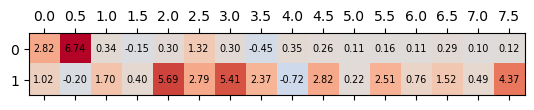

In [18]:
fig, ax = plt.subplots()
mat = ax.matshow(patch_scores.T, cmap='coolwarm', vmin=-(lim := np.max([np.abs(patch_scores.min()), np.abs(patch_scores.max())])), vmax=lim)
for i in range(patch_scores.T.shape[0]):
    for j in range(patch_scores.T.shape[1]):
        c = patch_scores.T[i,j]
        ax.text(j, i, f'{c:.2f}', va='center', ha='center', fontsize='x-small')
plt.xticks(np.arange(16), np.arange(16)/2)
plt.show()

Alright -- it looks like the `was` token was indeed important (MLP0), with attn2 and attn3 being important for bringing over this information from token 1 to token 2.

Which attention heads are most important?

In [22]:
patch_scores = np.zeros((12,2))

def hook_patch_value(activation, hook):
    activation[:, cur_token, cur_head, :] = cache[hook.name][:, cur_token, cur_head, :]
    return activation

for head in range(12):
    cur_head = head
    for i, token in enumerate(range(1,3)):
        cur_token = token
        with TranscoderReplacementContext(model, transcoders[:8]):
            with model.hooks(fwd_hooks=[('blocks.2.attn.hook_k', hook_patch_value), ('blocks.2.attn.hook_v', hook_patch_value)]):
                _, patched_cache = model.run_with_cache(bad_test_prompt)
                new_activation = transcoders[8](patched_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                old_activation = transcoders[8](bad_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                patch_scores[head, i] = new_activation-old_activation

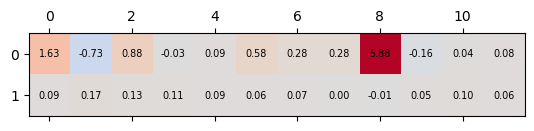

In [23]:
fig, ax = plt.subplots()
mat = ax.matshow(patch_scores.T, cmap='coolwarm', vmin=-(lim := np.max([np.abs(patch_scores.min()), np.abs(patch_scores.max())])), vmax=lim)
for i in range(patch_scores.T.shape[0]):
    for j in range(patch_scores.T.shape[1]):
        c = patch_scores.T[i,j]
        ax.text(j, i, f'{c:.2f}', va='center', ha='center', fontsize='x-small')
#plt.xticks(np.arange(16), np.arange(16)/2)
plt.show()

Looks like attn2 head 8 in particular was pretty important. How important is this head if we only patch the OV circuit?

In [20]:
patch_scores = np.zeros((12,2))

def hook_patch_value(activation, hook):
    activation[:, cur_token, cur_head, :] = cache[hook.name][:, cur_token, cur_head, :]
    return activation

for head in range(12):
    cur_head = head
    for i, token in enumerate(range(1,3)):
        cur_token = token
        with TranscoderReplacementContext(model, transcoders[:8]):
            with model.hooks(fwd_hooks=[(f'blocks.2.attn.hook_v', hook_patch_value)]):
                _, patched_cache = model.run_with_cache(bad_test_prompt)
                new_activation = transcoders[8](patched_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                old_activation = transcoders[8](bad_cache[utils.get_act_name('normalized8ln2')])[1][0,-1,feature_idx].item()
                patch_scores[head, i] = new_activation-old_activation

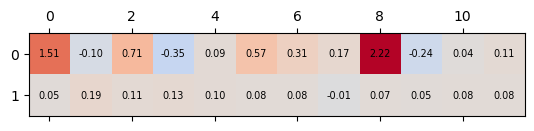

In [21]:
fig, ax = plt.subplots()
mat = ax.matshow(patch_scores.T, cmap='coolwarm', vmin=-(lim := np.max([np.abs(patch_scores.min()), np.abs(patch_scores.max())])), vmax=lim)
for i in range(patch_scores.T.shape[0]):
    for j in range(patch_scores.T.shape[1]):
        c = patch_scores.T[i,j]
        ax.text(j, i, f'{c:.2f}', va='center', ha='center', fontsize='x-small')
#plt.xticks(np.arange(16), np.arange(16)/2)
plt.show()

Still important, but not quite as much. Note that it's currently a limitation of our circuit analysis tool that it isn't able to fully take into account the QK circuit simultaneously with the OV circuit.

Now that we see that attn2 is important, does it directly contribute to the layer 8 transcoder feature? 

In [58]:
transcoders[8].W_enc[:,feature_idx] @ bad_cache[utils.get_act_name('attn_out', 2)][0, 1]

tensor(0.3081, device='cuda:0', grad_fn=<DotBackward0>)

Barely any direct contribution! This suggests a possible reason why the contribution of attn2head8 doesn't show up in the list of computational paths is because its contribution is *diffuse*: it might be the case that attn2head8 contributes via a large number of computational paths that are individually rather unimportant. If this is the case, then the individual computational paths will get pruned by the greedy search algorithm, thus obscuring attn2head8's contribution.

To address this, we'll work backwards: which features does the post-attn2 residual stream of the prompt containing the token "was" activate more than the prompt without "was"?

In [98]:
for l in range(2,8):
    print(f"Layer {l}:")
    with torch.no_grad():
        v, i = torch.topk(    (transcoders[l](cache[utils.get_act_name('normalized', 2, 'ln2')])[1][0,-1]\
            - transcoders[l](bad_cache[utils.get_act_name('normalized', 2, 'ln2')])[1][0,-1]) * (transcoders[l].W_dec @ transcoders[8].W_enc[:, feature_idx]),
            k = 5
        )
    print(f"\t{v}\n\t{i}")

Layer 2:
	tensor([0.5727, 0.5548, 0.5458, 0.4265, 0.1927], device='cuda:0')
	tensor([ 6202, 17511, 17771, 16079,  9225], device='cuda:0')
Layer 3:
	tensor([1.4671, 0.4383, 0.1087, 0.0423, 0.0325], device='cuda:0')
	tensor([ 7628, 14572, 15799, 24460, 15199], device='cuda:0')
Layer 4:
	tensor([1.1604, 0.5468, 0.3648, 0.1943, 0.1893], device='cuda:0')
	tensor([21770, 11288,  1746, 17103, 12869], device='cuda:0')
Layer 5:
	tensor([0.7566, 0.2285, 0.0978, 0.0899, 0.0598], device='cuda:0')
	tensor([11575,  9807,  9375,  1493,  9050], device='cuda:0')
Layer 6:
	tensor([0.8048, 0.7340, 0.1324, 0.0579, 0.0517], device='cuda:0')
	tensor([ 3358, 22733, 11280,  7212,  8247], device='cuda:0')
Layer 7:
	tensor([1.2310, 0.3090, 0.2683, 0.0531, 0.0441], device='cuda:0')
	tensor([14382,  5675,  4614,  7291,  9533], device='cuda:0')


The next question: do any of these features show up in the top computational paths?

In [91]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature,
                                 num_iters=1, num_branches=30, do_raw_attribution=True, filter=FeatureFilter(feature_type=FeatureType.TRANSCODER))

In [92]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[14382]@2: 4.3
Path [0][1]: mlp8tc[235]@-1: 1.9e+01 <- mlp0tc[1636]@2: 3.9
Path [0][2]: mlp8tc[235]@-1: 1.9e+01 <- mlp3tc[7628]@2: 1.6
Path [0][3]: mlp8tc[235]@-1: 1.9e+01 <- mlp6tc[22733]@2: 1.6
Path [0][4]: mlp8tc[235]@-1: 1.9e+01 <- mlp4tc[21770]@2: 1.3
Path [0][5]: mlp8tc[235]@-1: 1.9e+01 <- mlp5tc[11575]@2: 1.2
Path [0][6]: mlp8tc[235]@-1: 1.9e+01 <- mlp2tc[17511]@2: 1.1
Path [0][7]: mlp8tc[235]@-1: 1.9e+01 <- mlp1tc[4598]@2: 0.99
Path [0][8]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[18519]@2: 0.4
Path [0][9]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[760]@2: 0.23
Path [0][10]: mlp8tc[235]@-1: 1.9e+01 <- mlp3tc[14572]@2: 0.21
Path [0][11]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[11008]@2: 0.19
Path [0][12]: mlp8tc[235]@-1: 1.9e+01 <- mlp4tc[6945]@2: 0.16
Path [0][13]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[6318]@2: 0.15
Path [0][14]: mlp8tc[235]@-1: 1.9e+01 <- mlp7tc[5675]@2: 0.15
Path [0][15]: mlp8tc[235]@-1: 1.9e+01 <- mlp0tc[7058]@2: 

They do! Many of the top transcoder features for causing this feature to activate are the ones that the post-attn2 residual stream in the "was" prompt causes to activate the most when compared with the non-"was" prompt. But what happens when we try to reverse-engineer some of these features?

In [105]:
subcircuit = greedy_get_top_paths(model, transcoders, cache, all_paths[0][4][-1], num_iters=1, num_branches=20, do_raw_attribution=True)
print_all_paths(subcircuit)

--- Paths of size 2 ---
Path [0][0]: mlp4tc[21770]@2: 1e+01 <- mlp0tc[1636]@2: 0.25
Path [0][1]: mlp4tc[21770]@2: 1e+01 <- mlp3tc[7628]@2: 0.1
Path [0][2]: mlp4tc[21770]@2: 1e+01 <- mlp1tc[4598]@2: 0.081
Path [0][3]: mlp4tc[21770]@2: 1e+01 <- mlp2tc[17511]@2: 0.069
Path [0][4]: mlp4tc[21770]@2: 1e+01 <- attn3[2]@1: 0.03
Path [0][5]: mlp4tc[21770]@2: 1e+01 <- attn0[4]@2: 0.026
Path [0][6]: mlp4tc[21770]@2: 1e+01 <- attn2[2]@1: 0.023
Path [0][7]: mlp4tc[21770]@2: 1e+01 <- mlp3tc[14572]@2: 0.021
Path [0][8]: mlp4tc[21770]@2: 1e+01 <- attn0[5]@2: 0.017
Path [0][9]: mlp4tc[21770]@2: 1e+01 <- attn0[1]@2: 0.017
Path [0][10]: mlp4tc[21770]@2: 1e+01 <- attn1[0]@1: 0.015
Path [0][11]: mlp4tc[21770]@2: 1e+01 <- attn2[8]@1: 0.015
Path [0][12]: mlp4tc[21770]@2: 1e+01 <- mlp3tc[15799]@2: 0.012
Path [0][13]: mlp4tc[21770]@2: 1e+01 <- attn3[11]@2: 0.011
Path [0][14]: mlp4tc[21770]@2: 1e+01 <- embed0@2: 0.011
Path [0][15]: mlp4tc[21770]@2: 1e+01 <- attn3[9]@1: 0.0087
Path [0][16]: mlp4tc[21770]@2: 1e+0

Although we do see contributions from the "was" token (e.g. `attn2[2]@1: 0.023`, `attn2[8]@1: 0.015`), they're very small. This provides further support for the previous hypothesis regarding why attn2 isn't found to be important by the greedy algorithm: it seems to make a lot of slight individual contributions via a large number of computational paths.

What if we try to combine all these computational paths into a graph?

In [113]:
all_paths = greedy_get_top_paths(model, transcoders, cache, my_feature,
                                 num_iters=3, num_branches=60, do_raw_attribution=True)

In [122]:
filtered_paths = get_paths_via_filter(all_paths, suffix_path=[FeatureFilter(token=1, )])

In [123]:
print_all_paths(filtered_paths)

Path [0]: mlp8tc[235]@-1: 1.9e+01 <- attn3[2]@1: 0.21
Path [1]: mlp8tc[235]@-1: 1.9e+01 <- attn2[0]@1: 0.16
Path [2]: mlp8tc[235]@-1: 1.9e+01 <- attn2[8]@1: 0.15
Path [3]: mlp8tc[235]@-1: 1.9e+01 <- attn3[8]@1: 0.13
Path [4]: mlp8tc[235]@-1: 1.9e+01 <- attn1[1]@1: 0.099
Path [5]: mlp8tc[235]@-1: 1.9e+01 <- attn1[0]@1: 0.094
Path [6]: mlp8tc[235]@-1: 1.9e+01 <- attn1[10]@1: 0.093
Path [7]: mlp8tc[235]@-1: 1.9e+01 <- attn2[8]@1: 0.15 <- mlp0tc[17133]@1: 0.19
Path [8]: mlp8tc[235]@-1: 1.9e+01 <- mlp2tc[6202]@2: 0.13 <- attn2[5]@1: 0.18
Path [9]: mlp8tc[235]@-1: 1.9e+01 <- mlp3tc[14572]@2: 0.21 <- attn3[2]@1: 0.17
Path [10]: mlp8tc[235]@-1: 1.9e+01 <- attn3[2]@1: 0.21 <- mlp0tc[17133]@1: 0.12
Path [11]: mlp8tc[235]@-1: 1.9e+01 <- mlp3tc[7628]@2: 1.6 <- attn3[2]@1: 0.12
Path [12]: mlp8tc[235]@-1: 1.9e+01 <- attn2[8]@1: 0.15 <- mlp0tc[17133]@1: 0.19 <- embed0@1: 0.11


In [124]:
_, filtered_nodes = paths_to_graph(filtered_paths)
filtered_nodes

{'mlp8tc[235]@-1': <FeatureVector object mlp8tc[235]@-1: 1.9e+01, sublayer=resid_mid>,
 'mlp0tc[17133]@1': <FeatureVector object mlp0tc[17133]@1: 0.31, sublayer=resid_mid contrib_type=raw>,
 'mlp2tc[6202]@2': <FeatureVector object mlp2tc[6202]@2: 0.13, sublayer=resid_mid contrib_type=raw>,
 'mlp3tc[14572]@2': <FeatureVector object mlp3tc[14572]@2: 0.21, sublayer=resid_mid contrib_type=raw>,
 'mlp3tc[7628]@2': <FeatureVector object mlp3tc[7628]@2: 1.6, sublayer=resid_mid contrib_type=raw>,
 'embed0@1': <FeatureVector object mlp0tc[17133]embed0@1: 0.11, sublayer=resid_pre contrib_type=raw>,
 'attn3[2]@1': <FeatureVector object attn3[2]@1: 0.5, sublayer=resid_pre contrib_type=raw>,
 'attn2[0]@1': <FeatureVector object attn2[0]@1: 0.16, sublayer=resid_pre contrib_type=raw>,
 'attn2[8]@1': <FeatureVector object attn2[8]@1: 0.15, sublayer=resid_pre contrib_type=raw>,
 'attn3[8]@1': <FeatureVector object attn3[8]@1: 0.13, sublayer=resid_pre contrib_type=raw>,
 'attn1[1]@1': <FeatureVector obj

Nope: still very little attribution coming from token 1. When you look at the computational paths that end on token 1 (the "was" token), there are very few in the first place. This suggests that the greedy approach isn't the best for addressing this problem.